# **Assignment 3 : Face Recognition Using PCA & LDA**


In [28]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Generate the Data Matrix and the Label vector


In [29]:
paths = ["data/s" + str(i) for i in range(1, 41)]  # List of folder paths s1 to s40
cnt = 0
Data = np.zeros((400, 10304))  # Pre-allocate array for 400 images, each flattened to length 10304 (e.g., 112x92)
labels = np.zeros((400, 1))    # Pre-allocate labels array

# Assign label (subject ID) for each group of 10 images
for i in range(40):
    labels[i * 10 : (i + 1) * 10] = i + 1

# Loop through all folders and files to load and flatten images
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)  # Open image
        np_img = np.array(img)                # Convert to numpy array
        np_img = np_img.flatten()             # Flatten 2D image to 1D vector
        Data[cnt] = np_img                    # Store in Data array
        cnt += 1                             # Increment counter

### Data Visualization


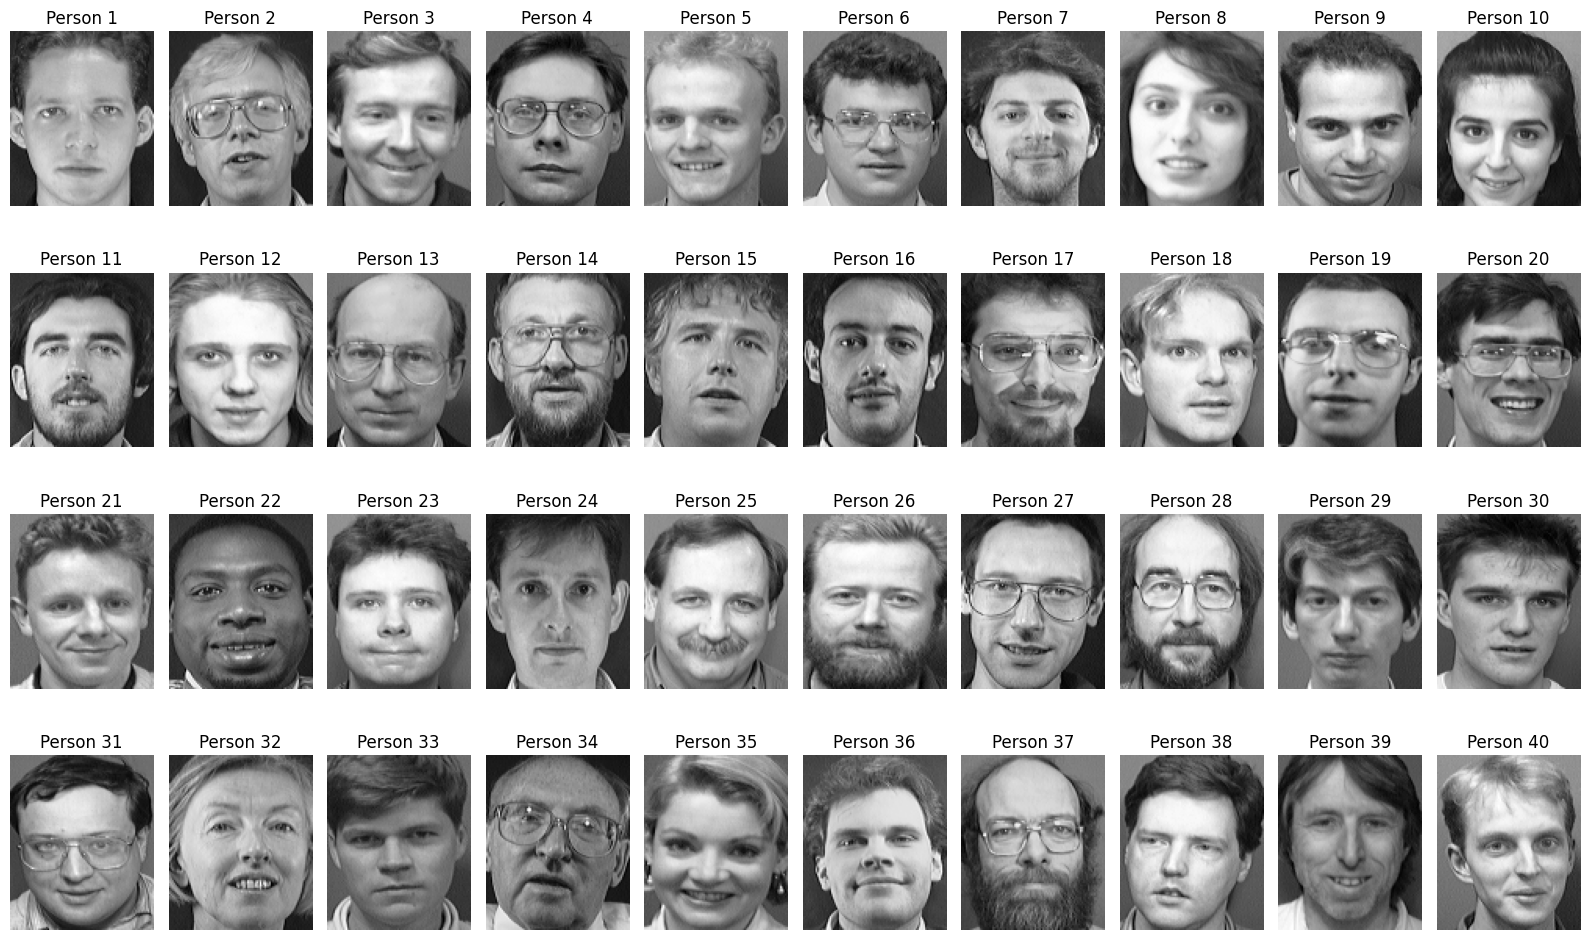

In [30]:
image_height = 112
image_width = 92

# Create a 4x10 grid of subplots
fig, axs = plt.subplots(4, 10, figsize=(16, 10))

# Flatten the 2D array of axes to 1D for easy indexing
axs = axs.ravel()

# Loop through 40 persons
for i in range(40):
    # Reshape the first image of each person into 2D
    image_array = Data[i * 10].reshape(image_height, image_width)
    
    # Display the image in grayscale
    axs[i].imshow(image_array, cmap="gray")
    
    # Set title as the person number (1-indexed)
    axs[i].set_title(f"Person {i + 1}")
    
    # Hide axes for cleaner look
    axs[i].axis("off")

plt.tight_layout()
plt.show()

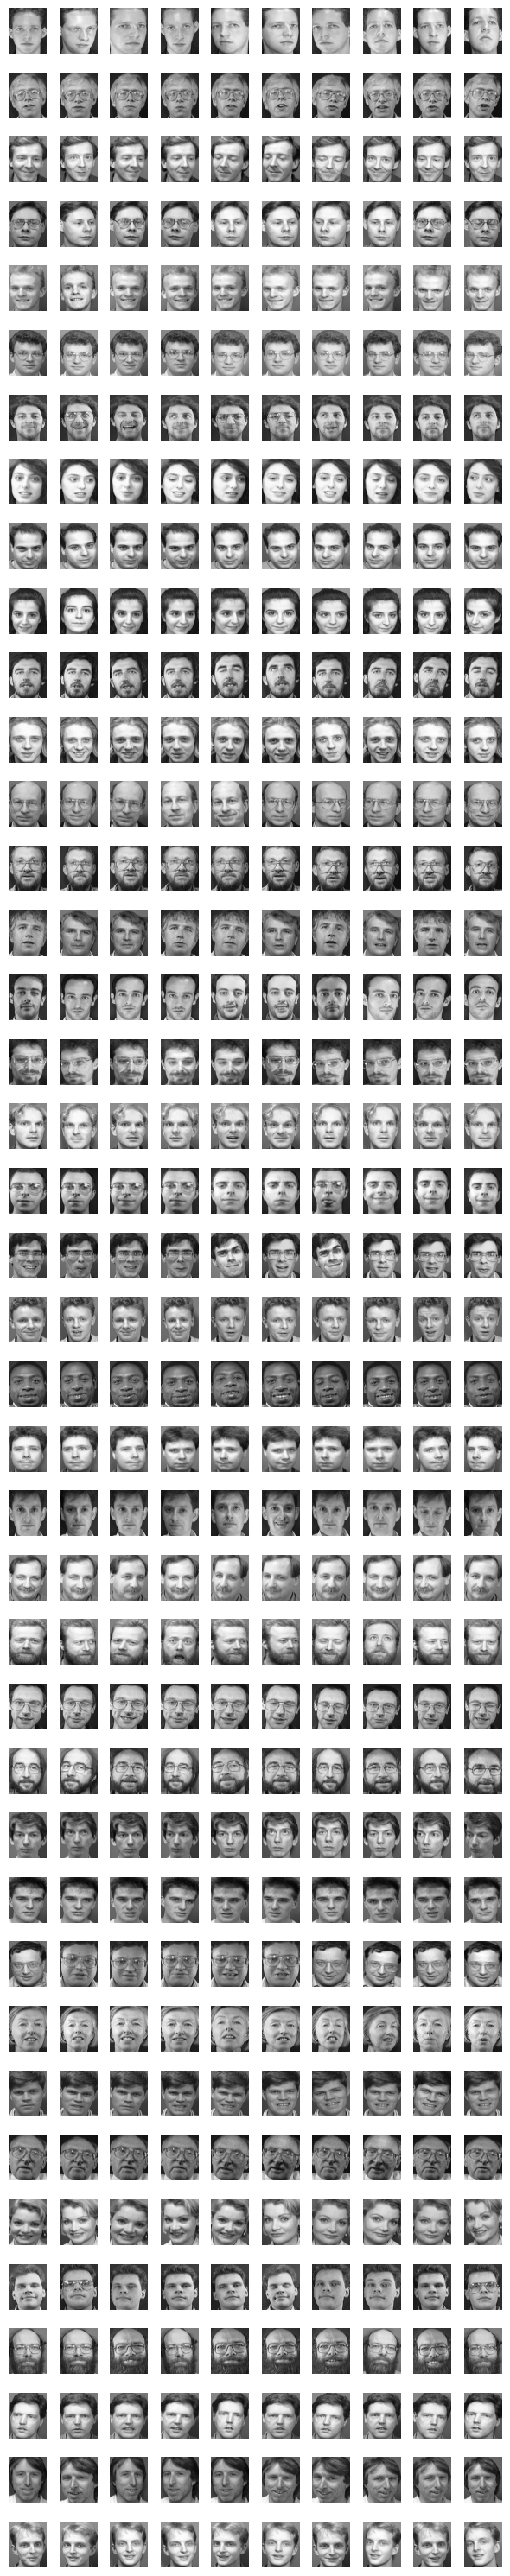

In [31]:
# Display images in a smaller overall figure
fig, axxr = plt.subplots(40, 10, figsize=(6, 30))  # Shrunk from (12, 60)
for i in range(40):
    for j in range(10):
        idx = i * 10 + j
        axxr[i][j].imshow(Data[idx].reshape(image_height, image_width), cmap='gray')
        axxr[i][j].axis('off')

plt.tight_layout()
plt.show()

## Splitting The Dataset


In [32]:
# Split the data: take every other sample for training and testing
X_train = Data[0::2]   # Even-indexed samples (0, 2, 4, ...) for training
X_test = Data[1::2]    # Odd-indexed samples (1, 3, 5, ...) for testing

# Split the labels in the same way to match the data
y_train = labels[0::2]
y_test = labels[1::2]

# Show the shapes of the resulting arrays
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


# PCA


In [33]:
def get_PCA(training_data, alpha):
    # Compute the mean of the training data
    mean_face = np.mean(training_data, axis=0)
    # subtract the mean from the training data
    training_data_centralized = training_data - mean_face
    # compute the covariance matrix
    cov_matrix = training_data_centralized @ training_data_centralized.T
    # compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    # sort the eigenvectors descindigly by eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # restore the original eigenvectors
    eigenvectors_converted = training_data_centralized.T @ eigenvectors
    # normalize the eigenvectors_converted
    eigenfaces = eigenvectors_converted / np.linalg.norm(eigenvectors_converted, axis=0)
    # compute the number of components to keep
    sum = 0
    no_components = 0
    for i in range(len(eigenvalues)):
        sum += eigenvalues[i]
        no_components += 1
        if sum / np.sum(eigenvalues) >= alpha:
            break
    # project the training data on the eigenfaces
    return mean_face, eigenfaces[:, :no_components]


mean_face, eigenfaces = get_PCA(X_train, 0.8)
print(eigenfaces.shape)

(10304, 36)


## Projection training Data and Test data


In [34]:
def PCA_Projected_data(training_data,testing_data,mean_face, eigenfaces):
    X_train_centered = training_data - mean_face  # Center the data
    X_train_projected = X_train_centered @ eigenfaces  # Project onto eigenface space
    X_test_centered = testing_data - mean_face  # Center the data
    X_test_projected = X_test_centered @ eigenfaces  # Project onto eigenface space
    return X_train_projected, X_test_projected

## Plotting The first 5 Eigen Faces


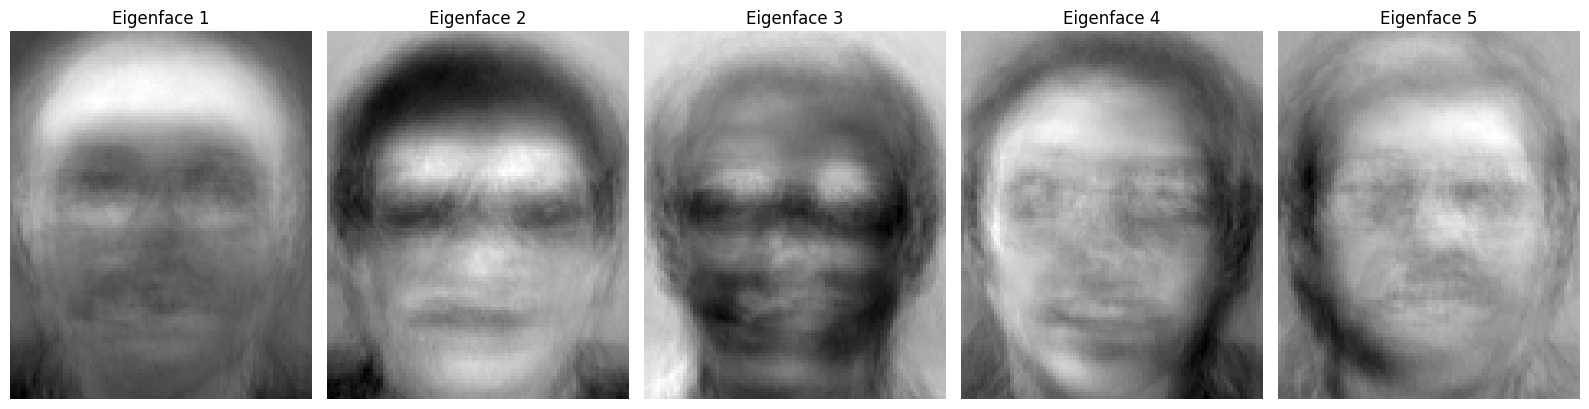

In [35]:
# Compute PCA to retain 95% of the variance
_, eigenfaces = get_PCA(X_train, 0.95)

# Plot the first 5 eigenfaces
fig, axs = plt.subplots(1, 5, figsize=(16, 10))
for i in range(5):
    # Reshape eigenface to original image dimensions
    image_array = eigenfaces[:, i].reshape(image_height, image_width)
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title(f"Eigenface {i + 1}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

### Test PCA


In [36]:
def Test_PCA(training_data, testing_data, training_labels, testing_labels, alpha, k):
    # Apply PCA to get the mean face and eigenfaces
    mean_face, eigenfaces = get_PCA(training_data, alpha)
    
    # Project both training and testing data onto the PCA space
    X_train_pca, X_test_pca = PCA_Projected_data(training_data, testing_data, mean_face, eigenfaces)
    
    # Train KNN classifier on projected training data
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train_pca, training_labels.ravel())
    
    # Predict on test data and calculate accuracy
    y_pred = knn.predict(X_test_pca)
    accuracy = accuracy_score(testing_labels, y_pred.ravel())
    
    return accuracy

# Example usage
print("PCA Accuracy: " + str(Test_PCA(X_train, X_test, y_train, y_test, 0.85, 1)))

PCA Accuracy: 0.94


## Classifier Tuning for PCA


In [37]:
# Define PCA variance thresholds (alpha values) and KNN neighbor values to test
alphas = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]

# Initialize a DataFrame to store accuracy results for each (alpha, k) combination
df = pd.DataFrame(index=alphas, columns=k_values)

# Loop over each combination of alpha and k
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        # Evaluate accuracy using PCA followed by KNN classification
        accuracy = Test_PCA(X_train, X_test, y_train, y_test, num_dominant_eigen_vectors, k)

        # Store the accuracy in the DataFrame
        df.loc[num_dominant_eigen_vectors, k] = accuracy

# Display the accuracy results table
df

,1,3,5,7,9
0.80,0.94,0.905,0.895,0.88,0.835
0.85,0.94,0.9,0.895,0.855,0.83
0.90,0.94,0.905,0.89,0.855,0.815
0.95,0.93,0.9,0.865,0.83,0.805


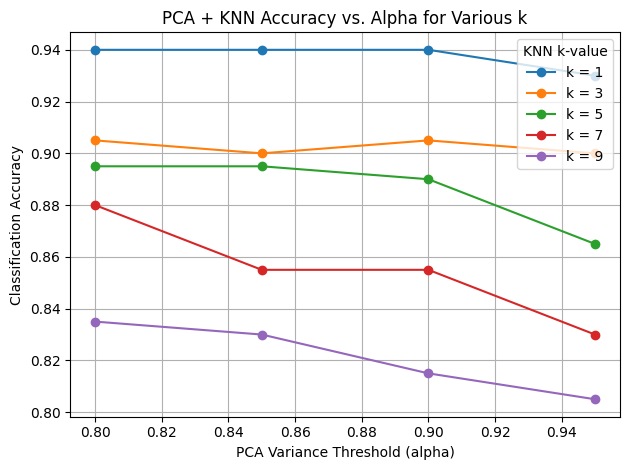

In [38]:
# Plot accuracy vs. alpha for each value of k
for k in k_values:
    plt.plot(df.index, df[k], marker="o", label=f"k = {k}")

plt.xlabel("PCA Variance Threshold (alpha)")
plt.ylabel("Classification Accuracy")
plt.title("PCA + KNN Accuracy vs. Alpha for Various k")
plt.legend(title="KNN k-value", loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# LDA


In [58]:
import numpy as np

def get_LDA(X_train, y_train):
    y_train = np.squeeze(y_train)
    classes = np.unique(y_train)
    n_classes = len(classes)

    # Compute class means and sizes
    class_means = np.array([np.mean(X_train[y_train == c], axis=0) for c in classes])
    class_sizes = np.array([np.sum(y_train == c) for c in classes])

    # Compute overall mean
    overall_mean = np.mean(X_train, axis=0)

    # Compute within-class scatter matrix
    S_W = np.zeros((X_train.shape[1], X_train.shape[1]))
    for i, c in enumerate(classes):
        class_data = X_train[y_train == c]
        centered_data = class_data - class_means[i]
        S_W += np.dot(centered_data.T, centered_data)

    # Regularize S_W
    S_W += 1e-7 * np.identity(X_train.shape[1])

    # Compute between-class scatter matrix
    S_B = np.zeros((X_train.shape[1], X_train.shape[1]))
    for i, c in enumerate(classes):
        class_diff = class_means[i] - overall_mean
        S_B += class_sizes[i] * np.outer(class_diff, class_diff)

    # Solve the generalized eigenvalue problem for inv(S_W) * S_B
    eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.inv(S_W) @ S_B)

    # Sort eigenvectors by descending eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, idx]

    # Project to at most (n_classes - 1) dimensions
    projection_matrix = sorted_eigenvectors[:, :n_classes - 1]
    return np.real(projection_matrix)

## The Projection Matrix of LDA


In [59]:
# Compute the LDA transformation matrix based on the training data and labels.
LDA_projection_matrix = get_LDA(X_train,y_train)
print(LDA_projection_matrix.shape)

(10304, 39)


## LDA Projection


In [60]:
def LDA_projected_data(training_data, test_data, projection_matrix):
    # Project the training and test data onto the LDA subspace
    projected_X_train = np.dot(training_data, projection_matrix)
    projected_X_test = np.dot(test_data, projection_matrix)

    return projected_X_train, projected_X_test

### Test LDA


In [61]:
def Test_LDA(k):
    # Project training and testing data to LDA subspace
    projected_X_train, projected_X_test = LDA_projected_data(X_train, X_test, LDA_projection_matrix)

    # Train KNN classifier on LDA-projected training data
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(projected_X_train, y_train.ravel())

    # Predict test labels and calculate accuracy
    y_pred = knn.predict(projected_X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    return accuracy

# Print accuracy for k=1
print("LDA Accuracy: " + str(Test_LDA(1)))

LDA Accuracy: 0.96


## Classifier Tuning for LDA


In [62]:
k_values = [1, 3, 5, 7, 9]

# List to store accuracy results
results = []

# Project training and test data into LDA subspace
projected_X_train, projected_X_test = LDA_projected_data(X_train, X_test, LDA_projection_matrix)

# Evaluate KNN with different k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(projected_X_train, y_train.ravel())
    y_pred = knn.predict(projected_X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    results.append({"accuracy": accuracy})

# Create a DataFrame to display the results
df = pd.DataFrame(results, index=k_values)
df.index.name = "k"
df

,accuracy
k,
1,0.960
3,0.935
5,0.925
7,0.925
9,0.915


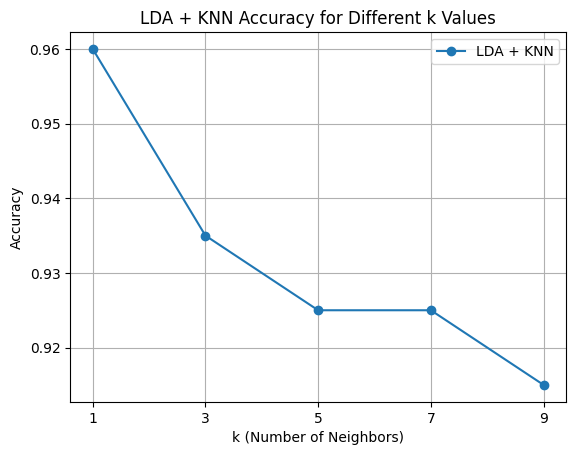

In [63]:
# Plot accuracy vs. k
plt.plot(df.index, df["accuracy"], marker="o", label="LDA + KNN")

plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("LDA + KNN Accuracy for Different k Values")
plt.grid(True)
plt.xticks(df.index)  # Ensure only tested k-values appear
plt.legend()
plt.show()

## Comparison Between PCA & LDA


### Accuracy of PCA VS LDA with respect to K (number of nearest neighbours)


In [64]:
alphas = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
variants = [f"PCA α = {a}" for a in alphas] + ["LDA"]

# Initialize DataFrame
df = pd.DataFrame(index=variants, columns=k_values)

# Loop over k values
for k in k_values:
    # Evaluate PCA for each alpha
    for alpha_val in alphas:
        variant_name = f"PCA α = {alpha_val}"
        pca_accuracy = Test_PCA(X_train, X_test, y_train, y_test, alpha_val, k)
        df.loc[variant_name, k] = f"{pca_accuracy * 100:.2f}%"
    
    # Evaluate LDA
    lda_accuracy = Test_LDA(k)
    df.loc["LDA", k] = f"{lda_accuracy * 100:.2f}%"

df

,1,3,5,7,9
PCA α = 0.8,94.00%,90.50%,89.50%,88.00%,83.50%
PCA α = 0.85,94.00%,90.00%,89.50%,85.50%,83.00%
PCA α = 0.9,94.00%,90.50%,89.00%,85.50%,81.50%
PCA α = 0.95,93.00%,90.00%,86.50%,83.00%,80.50%
LDA,96.00%,92.00%,91.50%,89.50%,87.00%


## Splitting Data 70% Train and 30% Test

In [65]:
def split_data(data, labels):
    """
    Splits the dataset so that each of the 40 subjects contributes:
    - 7 images to the training set
    - 3 images to the testing set
    Also shuffles the training set.

    Parameters:
    - data: numpy array of shape (400, 10304) containing flattened image data
    - labels: numpy array of shape (400, 1) containing corresponding labels

    Returns:
    - X_train, X_test, y_train, y_test: split and shuffled datasets
    """

    # Initialize arrays for training and testing data
    X_train = np.zeros((280, 10304))
    X_test = np.zeros((120, 10304))
    y_train = np.zeros((280, 1))
    y_test = np.zeros((120, 1))

    # Split data for each subject: first 7 images for training, last 3 for testing
    for i in range(40):
        X_train[i * 7 : (i + 1) * 7] = data[i * 10 : i * 10 + 7]
        X_test[i * 3 : (i + 1) * 3] = data[i * 10 + 7 : i * 10 + 10]
        y_train[i * 7 : (i + 1) * 7] = labels[i * 10 : i * 10 + 7]
        y_test[i * 3 : (i + 1) * 3] = labels[i * 10 + 7 : i * 10 + 10]

    # Shuffle training data
    indices = np.arange(280)
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    return X_train, X_test, y_train, y_test

In [66]:
# Perform the data split
X_train_bonus, X_test_bonus, y_train_bonus, y_test_bonus = split_data(Data, labels)

In [67]:
# Compute PCA on training data (retain 85% variance)
mean_face, eigenfaces = get_PCA(X_train_bonus, 0.85)

# Project training and testing data onto PCA components
X_train_pca_bonus, X_test_pca_bonus = PCA_Projected_data(X_train_bonus, X_test_bonus, mean_face, eigenfaces)

# Train KNN classifier with k=1 and distance weighting
knn = KNeighborsClassifier(n_neighbors=1, weights="distance")
knn.fit(X_train_pca_bonus, y_train_bonus.ravel())

# Predict test labels
y_pred = knn.predict(X_test_pca_bonus)

# Calculate accuracy
accuracy = accuracy_score(y_test_bonus, y_pred.ravel())
print("PCA Accuracy:", accuracy)

PCA Accuracy: 0.9583333333333334


### Comparison Between Ordinary Split and Train Split in PCA

In [68]:
alpha = [0.8, 0.85, 0.9, 0.95]  # PCA variance retention levels
k = 1  # Number of neighbors for KNN
df = pd.DataFrame(index=alpha, columns=["Original Split", "Bonus Split"])

for var_retention in alpha:
    # Evaluate PCA + KNN on original train/test split
    original_acc = Test_PCA(X_train, X_test, y_train, y_test, var_retention, k)
    df.loc[var_retention, "Original Split"] = original_acc
    
    # Evaluate PCA + KNN on bonus train/test split (7 train, 3 test per person)
    bonus_acc = Test_PCA(X_train_bonus, X_test_bonus, y_train_bonus, y_test_bonus, var_retention, k)
    df.loc[var_retention, "Bonus Split"] = bonus_acc

df

,Original Split,Bonus Split
0.80,0.94,0.966667
0.85,0.94,0.958333
0.90,0.94,0.95
0.95,0.93,0.941667


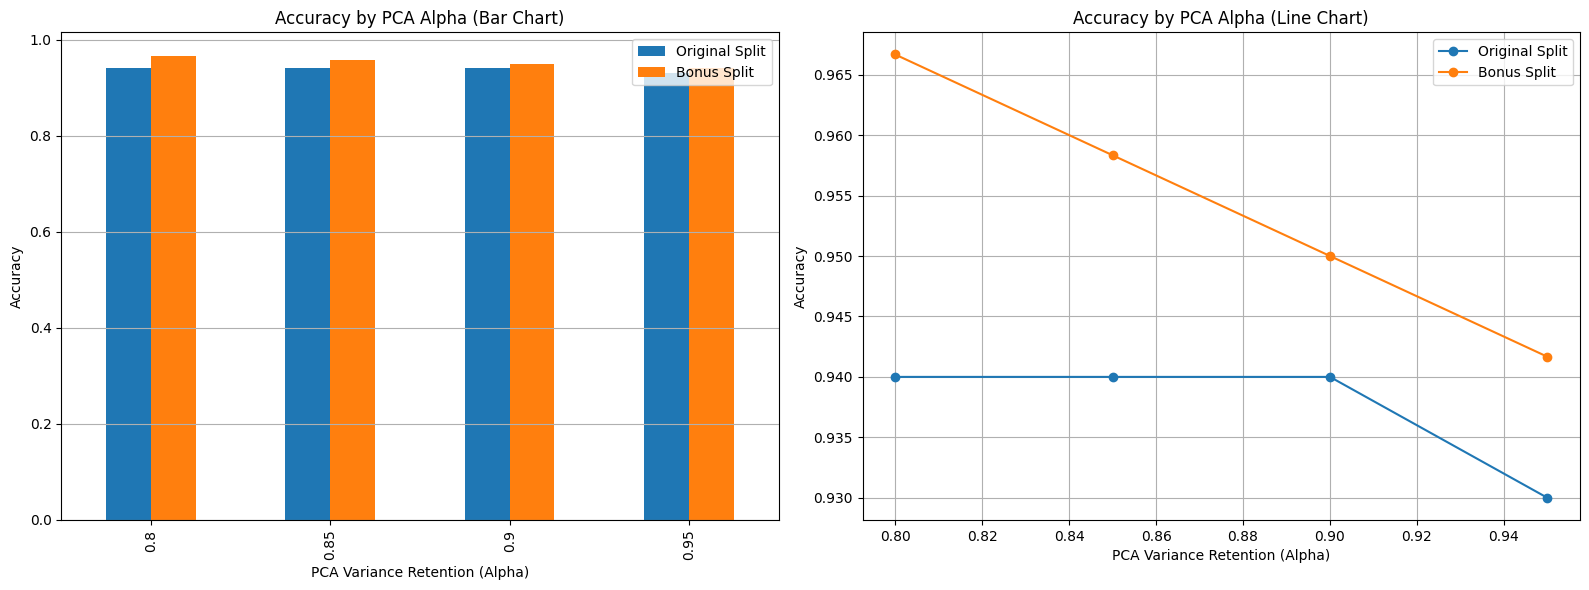

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of accuracy for different PCA alphas and splits
df.plot(kind="bar", ax=ax[0])
ax[0].set_title("Accuracy by PCA Alpha (Bar Chart)")
ax[0].set_xlabel("PCA Variance Retention (Alpha)")
ax[0].set_ylabel("Accuracy")
ax[0].grid(True, axis='y')

# Line chart with markers for the same data
df.plot(kind="line", ax=ax[1], marker="o")
ax[1].set_title("Accuracy by PCA Alpha (Line Chart)")
ax[1].set_xlabel("PCA Variance Retention (Alpha)")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Comparison Between Ordinary Split and Bonus Split in LDA

In [70]:
# This function trains a k-NN classifier and returns both accuracy and predicted labels
def get_acc(X_train, X_test, y_train, y_test, k):
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train, y_train.ravel())  # Train the model
    y_pred = knn.predict(X_test)      # Make predictions on the test set
    accuracy = accuracy_score(y_test, y_pred.ravel())  # Calculate accuracy
    return accuracy, y_pred  # Return both accuracy and predictions

# Compute LDA projection matrix using the bonus training data and labels
Bonus_LDA_projection_matrix = get_LDA(X_train_bonus, y_train_bonus)

# Project training and testing data using the computed LDA matrix
projected_X_train, projected_X_test = LDA_projected_data(X_train_bonus, X_test_bonus, LDA_projection_matrix)

# Calculate accuracy of KNN classifier on LDA projected data with k=1
acc_Lda_07, _ = get_acc(projected_X_train, projected_X_test, y_train_bonus, y_test_bonus, 1)

# Print the accuracy result
print("LDA Accuracy: " + str(acc_Lda_07))

LDA Accuracy: 0.975


In [71]:
# Create an empty DataFrame with columns for the two data splits
df = pd.DataFrame(index=[], columns=["Original Split", "Bonus Split"])

# Add LDA accuracy for the original train/test split (using k=1)
df.loc["LDA", "Original Split"] = Test_LDA(1)

# Add LDA accuracy for the bonus train/test split (precomputed earlier)
df.loc["LDA", "Bonus Split"] = acc_Lda_07

# Display the DataFrame with LDA accuracy results for both splits
df

,Original Split,Bonus Split
LDA,0.96,0.975


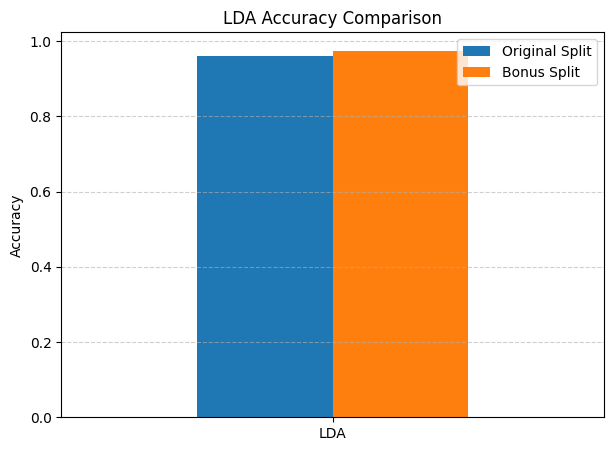

In [72]:
# Plot LDA accuracy for original and bonus splits
df.plot(kind="bar", rot=0, figsize=(7,5))
plt.title("LDA Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Compare vs Non-Face Images

In [73]:
def readd(R):
    """
    Reads 400 face images and R non-face (turtle) images, resizes all to 92x112, and flattens them.

    Parameters:
    - R: Number of non-face images to load.

    Returns:
    - faces: Numpy array of shape ((400+R), 10304) containing flattened image data.
    - target: Numpy array of shape ((400+R), 1) containing labels (1 for face, 0 for non-face).
    """
    faces_data = []
    labels = []

    # Load face images
    for i in range(1, 41):
        for j in range(1, 11):
            path = f'data/s{i}/{j}.pgm'
            if os.path.exists(path):
                image = plt.imread(path)
                image = image.transpose()
                faces_data.append(image.flatten())
                labels.append(1)
            else:
                print(f"Warning: Face image not found at {path}")

    # Load non-face (turtle) images
    for i in range(1, R + 1):
        path = f'archive/Turtle_Tortoise ({i}).jpg'
        if os.path.exists(path):
            image = plt.imread(path)
            if image.ndim == 3:  # Ensure image has color channels
                image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                image_gray = image  # Already grayscale

            resized_image = cv2.resize(image_gray, (92, 112))
            resized_image = resized_image.transpose()
            faces_data.append(resized_image.flatten())
            labels.append(0)
        else:
            print(f"Warning: Non-face image not found at {path}")

    faces_array = np.array(faces_data)
    labels_array = np.array(labels).reshape(-1, 1)

    return faces_array, labels_array

In [74]:
# This function creates and displays a confusion matrix
def plot_conf_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Face", "Non-Face"])
    disp.plot(cmap="Blues")  # Plot with blue color map
    plt.title(title)
    plt.grid(False)
    plt.show()

## LDA 200 images

In [75]:
fn1,tn1=readd(200)
X_train_bonus1, X_test_bonus1, y_train_bonus1, y_test_bonus1 = train_test_split(fn1, tn1, test_size=0.5, random_state=42,stratify = tn1)
print(tn1.shape)

(600, 1)


In [76]:
# Compute the LDA transformation matrix based on the training data and labels.
LDA_projection_matrix1 = get_LDA(X_train_bonus1,y_train_bonus1)
print(LDA_projection_matrix1.shape)

(10304, 1)


LDA Accuracy: 0.8933333333333333


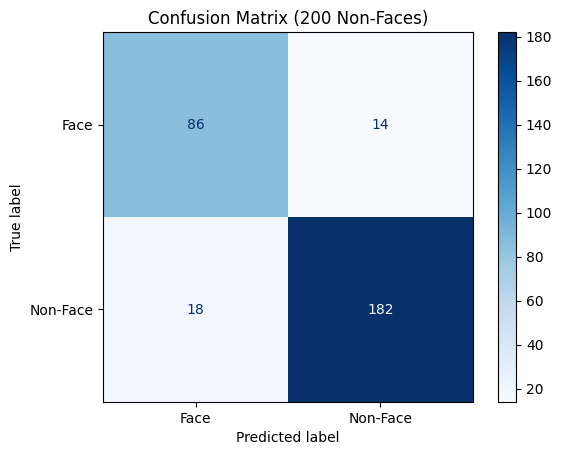

In [77]:
# Project training and testing data using the computed LDA matrix
projected_X_train1, projected_X_test1 = LDA_projected_data(X_train_bonus1, X_test_bonus1, LDA_projection_matrix1)

# Calculate accuracy of KNN classifier on LDA projected data with k=1
acc_Lda_01, y_pred_1 = get_acc(projected_X_train1, projected_X_test1, y_train_bonus1, y_test_bonus1, 1)

# Print the accuracy result
print("LDA Accuracy: " + str(acc_Lda_01))

# Plot confusion matrix for the 200 non-face setup
plot_conf_matrix(y_test_bonus1, y_pred_1, title="Confusion Matrix (200 Non-Faces)")

## PCA 200 images

In [78]:
# Compute PCA on training data (retain 85% variance)
mean_face1, eigenfaces1 = get_PCA(X_train_bonus1, 0.85)

# Project training and testing data onto PCA components
X_train_pca_bonus1, X_test_pca_bonus1 = PCA_Projected_data(X_train_bonus1, X_test_bonus1, mean_face1, eigenfaces1)

# Train KNN classifier with k=1 and distance weighting
knn = KNeighborsClassifier(n_neighbors=1, weights="distance")
knn.fit(X_train_pca_bonus1, y_train_bonus1.ravel())

# Predict test labels
y_pred1 = knn.predict(X_test_pca_bonus1)

# Calculate accuracy
accuracy1 = accuracy_score(y_test_bonus1, y_pred1.ravel())
print("PCA Accuracy:", accuracy1)

PCA Accuracy: 0.9733333333333334


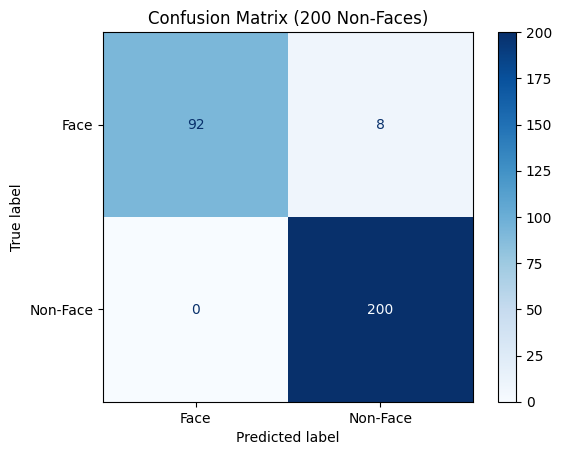

In [79]:
# Plot confusion matrix for the 200 non-face setup
plot_conf_matrix(y_test_bonus1, y_pred1, title="Confusion Matrix (200 Non-Faces)")

## LDA 400 images

In [80]:
fn2,tn2=readd(400)
X_train_bonus2, X_test_bonus2, y_train_bonus2, y_test_bonus2 = train_test_split(fn2, tn2, test_size=0.5, random_state=42,stratify = tn2)
print(tn2.shape)

(800, 1)


In [81]:
# Compute the LDA transformation matrix based on the training data and labels.
LDA_projection_matrix2 = get_LDA(X_train_bonus2,y_train_bonus2)
print(LDA_projection_matrix2.shape)

(10304, 1)


LDA Accuracy: 0.8925


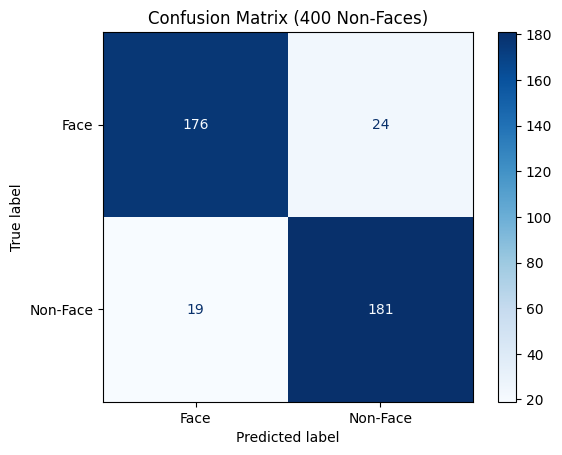

In [82]:
# Project training and testing data using the computed LDA matrix
projected_X_train2, projected_X_test2 = LDA_projected_data(X_train_bonus2, X_test_bonus2, LDA_projection_matrix2)

# Calculate accuracy of KNN classifier on LDA projected data with k=1
acc_Lda_02, y_pred_2 = get_acc(projected_X_train2, projected_X_test2, y_train_bonus2, y_test_bonus2, 1)

# Print the accuracy result
print("LDA Accuracy: " + str(acc_Lda_02))

# Plot confusion matrix for the 400 non-face setup
plot_conf_matrix(y_test_bonus2, y_pred_2, title="Confusion Matrix (400 Non-Faces)")

## PCA 400 images

In [83]:
# Compute PCA on training data (retain 85% variance)
mean_face2, eigenfaces2 = get_PCA(X_train_bonus2, 0.85)

# Project training and testing data onto PCA components
X_train_pca_bonus2, X_test_pca_bonus2 = PCA_Projected_data(X_train_bonus2, X_test_bonus2, mean_face2, eigenfaces2)

# Train KNN classifier with k=1 and distance weighting
knn = KNeighborsClassifier(n_neighbors=1, weights="distance")
knn.fit(X_train_pca_bonus2, y_train_bonus2.ravel())

# Predict test labels
y_pred2 = knn.predict(X_test_pca_bonus2)

# Calculate accuracy
accuracy2 = accuracy_score(y_test_bonus2, y_pred2.ravel())
print("PCA Accuracy:", accuracy2)

PCA Accuracy: 0.9725


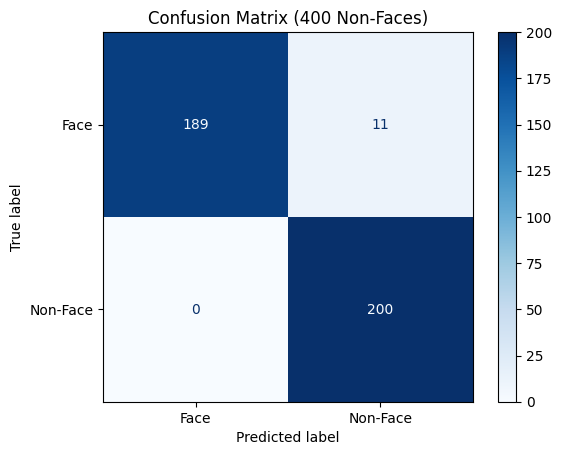

In [84]:
# Plot confusion matrix for the 400 non-face setup
plot_conf_matrix(y_test_bonus2, y_pred2, title="Confusion Matrix (400 Non-Faces)")

## LDA 600 images

In [85]:
fn3,tn3=readd(600)
X_train_bonus3, X_test_bonus3, y_train_bonus3, y_test_bonus3 = train_test_split(fn3, tn3, test_size=0.5, random_state=42,stratify = tn3)
print(tn3.shape)

(1000, 1)


In [86]:
# Compute the LDA transformation matrix based on the training data and labels.
LDA_projection_matrix3 = get_LDA(X_train_bonus3,y_train_bonus3)
print(LDA_projection_matrix3.shape)

(10304, 1)


LDA Accuracy: 0.884


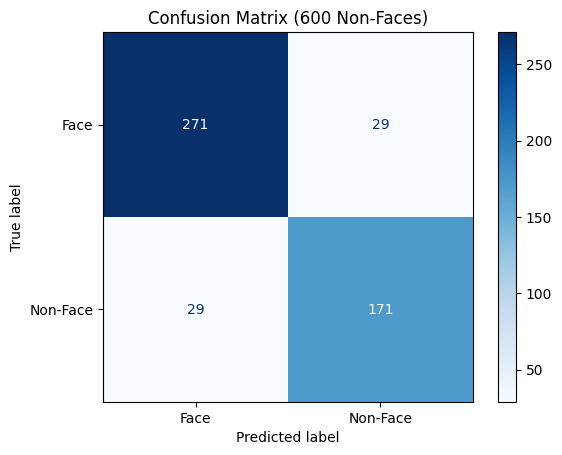

In [87]:
# Project training and testing data using the computed LDA matrix
projected_X_train3, projected_X_test3 = LDA_projected_data(X_train_bonus3, X_test_bonus3, LDA_projection_matrix3)

# Calculate accuracy of KNN classifier on LDA projected data with k=1
acc_Lda_03, y_pred_3 = get_acc(projected_X_train3, projected_X_test3, y_train_bonus3, y_test_bonus3, 1)

# Print the accuracy result
print("LDA Accuracy: " + str(acc_Lda_03))

# Plot confusion matrix for the 600 non-face setup
plot_conf_matrix(y_test_bonus3, y_pred_3, title="Confusion Matrix (600 Non-Faces)")

## PCA 600 images

In [88]:
# Compute PCA on training data (retain 85% variance)
mean_face3, eigenfaces3 = get_PCA(X_train_bonus3, 0.85)

# Project training and testing data onto PCA components
X_train_pca_bonus3, X_test_pca_bonus3 = PCA_Projected_data(X_train_bonus3, X_test_bonus3, mean_face3, eigenfaces3)

# Train KNN classifier with k=1 and distance weighting
knn = KNeighborsClassifier(n_neighbors=1, weights="distance")
knn.fit(X_train_pca_bonus3, y_train_bonus3.ravel())

# Predict test labels
y_pred3 = knn.predict(X_test_pca_bonus3)

# Calculate accuracy
accuracy3 = accuracy_score(y_test_bonus3, y_pred3.ravel())
print("PCA Accuracy:", accuracy3)

PCA Accuracy: 0.98


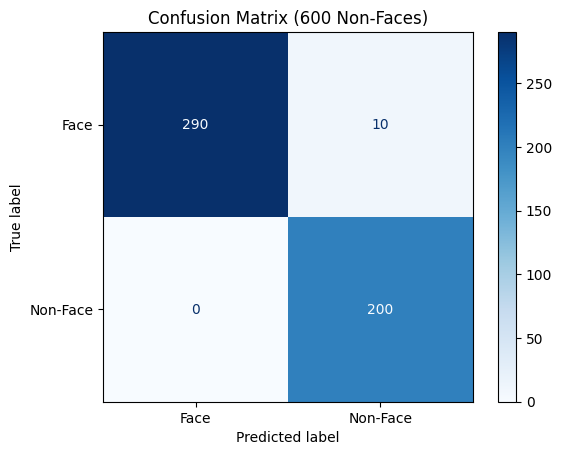

In [89]:
# Plot confusion matrix for the 600 non-face setup
plot_conf_matrix(y_test_bonus3, y_pred3, title="Confusion Matrix (600 Non-Faces)")

## LDA Accuracy vs. Number of Non-Face Images (Fixed Face Count)

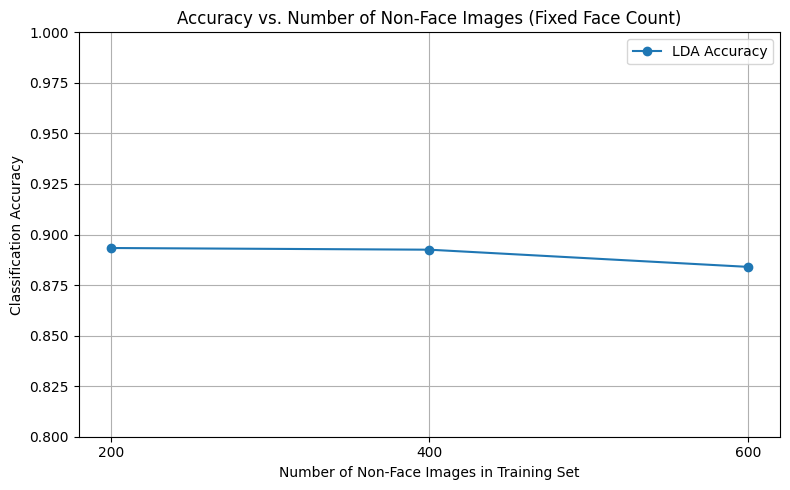

In [95]:
# Accuracy values for increasing number of non-face images
LDAn_y1 = np.array([acc_Lda_01, acc_Lda_02, acc_Lda_03])  # example accuracy values
LDAn_x1 = np.array([200, 400, 600])  # number of non-face images

# Plot with style and markers
plt.figure(figsize=(8, 5))
plt.plot(LDAn_x1, LDAn_y1, marker='o', linestyle='-', color='tab:blue', label='LDA Accuracy')

# Labels and grid
plt.xlabel("Number of Non-Face Images in Training Set")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy vs. Number of Non-Face Images (Fixed Face Count)")
plt.grid(True)
plt.xticks(LDAn_x1)
plt.ylim(0.8, 1)
plt.legend()
plt.tight_layout()
plt.show()

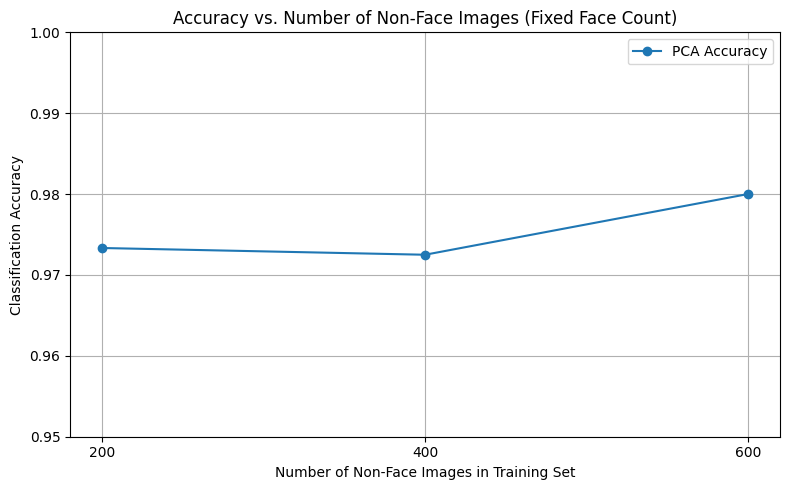

In [91]:
# Accuracy values for increasing number of non-face images
PCAn_y1 = np.array([accuracy1, accuracy2, accuracy3])  # example accuracy values
PCAn_x1 = np.array([200, 400, 600])  # number of non-face images

# Plot with style and markers
plt.figure(figsize=(8, 5))
plt.plot(PCAn_x1, PCAn_y1, marker='o', linestyle='-', color='tab:blue', label='PCA Accuracy')

# Labels and grid
plt.xlabel("Number of Non-Face Images in Training Set")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy vs. Number of Non-Face Images (Fixed Face Count)")
plt.grid(True)
plt.xticks(PCAn_x1)
plt.ylim(0.95, 1)
plt.legend()
plt.tight_layout()
plt.show()